# Data Collection for Capstone Project 2

This notebook goes over the data collection and processing steps followed for Springboard's 2nd Capstone Project. 

The aim of the project is create a regression model to predict PM25 values in Lucknow, India utilizing time, weather and other pollution (SO2, CO and so ON) as features. 
The future time frame to be used for prediction is yet to be selected(i.e. predicting for the next hour or next few days and so on)

The data was collected from two sources for 2016-July 2020.

1. Pollution Data: Hourly data collected from CPCB's website: http://www.cpcb.gov.in/CAAQM/frmUserAvgReportCriteria.aspx
The CPCB website only allows for collecting data on a maximum duration of three months for each variable. Thus there were multiple files for each variable over the considered time frame and had to merged as shown in the
subsequent cells below

2. Hourly weather data (Ambient and Dew Temperature) is obtained from the NOAA's database
https://www.ncei.noaa.gov/access/search/dataset-search

The process followed to generate the initial dataset is as follows:
1. Pollution Data
    a. Clean and merge all variable files to create quarterly files for all years.
    b. Join quarterly files to get datasets for each year
    c. Join all yearly datasets to get a single dataset for all pollution data
2. Weather Data
    a. Clean and merge all annual files for ambient and dew temperature
3. Merge the final pollution and weather data toghether

In [1]:
#Import all necessary modules
from collections import defaultdict
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
# This function was used to clean and standardize all quarterly variable files to generate a single pollution 
# dataset for each quarter.
# The inputs accepted were year and quarter to navigate to paths where files were located.
def DF_Joiner(year,quarter):

    path = '/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #2/Raw Data_CPCB_Lucknow/'
    year = str(year) + '/'
    Quarter = quarter + '_' + str(year)
    path1 = path + year + Quarter

# Create a list of strings of paths for all files in the path1 location

    Paths = glob.glob(path1+ '/*.xls')
# Define empty list to collect processed dataframes
    DFs = []
# Loop through all files in the path1 location to clean all the files in a standard manner and save as dataframes    
    for path in Paths:
        df = pd.read_html(path)[2]
        df1 = df.drop([0,(len(df)-1)])
        df1.columns = df1.loc[1]
        df1 = df1[1:]
        df1 = df1.rename(columns = {'Concentration':str(df1.iloc[0,0])+'_'+str(df1.iloc[0,5])})
        df1.drop(columns=['Parameter','Unit','Prescribed Standard','Exceeding Standard? (Yes/No)','Remarks'],inplace=True)
        df1.reset_index(inplace=True)
        df1.drop(columns=['index'],inplace=True)
        DFs.append(df1)
        
# Dictionary for renaming headers
    clmn_dict = {'Nitrogen Dioxide(NO2)_Âµg/mÂ³': 'NO2_ug_m3','Wind Direction (WD)_deg': 'Wind_dir_deg',
                 'PM 2.5(PM2.5)_Âµg/m3': 'PM_25_ug_m3','Ozone(O3)_Âµg/m3':'O3_ug_m3',
                 'Oxides of Nitrogen(NOx)_ppb': 'NOX_ppb','Carbon Monoxide(CO)_mg/m3':'CO_mg_m3',
                 'Wind Speed (WS)_m/s':'Wind_spd_m_s','Sulfur Dioxide(SO2)_Âµg/mÂ³':'SO2_ug_m3',
                 'Bar Pressure(BP)_mmHg':'Bar_P_mmHg','Relative Humidity(RH)_%':'Rel_Hum_%',
                 'Solar Radiation(SR)_W/m2': 'Solar_R_W_m2','Nitric Oxide(NO)_Âµg/m3':'NO_ug_m3',
                 'Temperature(Temp)_Â°C':'Temp_C','Nitrogen Dioxide(NO2)_nan': 'NO2_ug_m3',
                 'Wind Direction (WD)_nan': 'Wind_dir_deg','PM 2.5(PM2.5)_nan': 'PM_25_ug_m3',
                 'Ozone(O3)_nan':'O3_ug_m3','Oxides of Nitrogen(NOx)_nan': 'NOX_ppb',
                 'Carbon Monoxide(CO)_nan':'CO_mg_m3','Wind Speed (WS)_nan':'Wind_spd_m_s',
                 'Sulfur Dioxide(SO2)_nan':'SO2_ug_m3','Bar Pressure(BP)_nan':'Bar_P_mmHg',
                 'Relative Humidity(RH)_nan':'Rel_Hum_%','Solar Radiation(SR)_nan': 'Solar_R_W_m2',
                 'Nitric Oxide(NO)_nan':'NO_ug_m3','Temperature(Temp)_nan':'Temp_C'}
    df = DFs[0]

# Merge dataframes for all variables processed above using an outer join. Other merge methods such as left join
#were considered but not used due to losing some data. The NaN values generated for many variables 
#due to this method will be dealt with on a later stage in the final dataset

    for d in DFs[1:]:
        df = df.merge(d,how='outer',left_on=['From (Time)','To (Time)','Date'],right_on=['From (Time)','To (Time)','Date'])
    
    df = df.rename(columns = clmn_dict)
    
    columns = ['From (Time)','To (Time)','Date','PM_25_ug_m3','SO2_ug_m3','O3_ug_m3','CO_mg_m3','NOX_ppb','NO2_ug_m3',
               'NO_ug_m3','Temp_C','Rel_Hum_%','Wind_spd_m_s','Wind_dir_deg','Solar_R_W_m2','Bar_P_mmHg']

# Some quarters did not have data for all variables. For the time being, if such a variable was not present, 
# a column was created for it creating NaN values. This step was necessary while merging all the quarterly files

    for a in columns:
        if a not in df.columns:
            df[a] = np.nan
    df = df.rename(columns = clmn_dict)
    
# Reorder columns
    df = df[['From (Time)','To (Time)','Date','PM_25_ug_m3','SO2_ug_m3','O3_ug_m3','CO_mg_m3','NOX_ppb','NO2_ug_m3',
             'NO_ug_m3','Temp_C','Rel_Hum_%','Wind_spd_m_s','Wind_dir_deg','Solar_R_W_m2','Bar_P_mmHg']]
    return(df)

In [38]:
# Running the above function for generating and saving quarterly files. This step was followed for all quarters
# between 2016-July 2020

Q1_2016 = DF_Joiner(2016,'Q1')
Q1_2016.to_csv('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #2/Raw Data_CPCB_Lucknow/Cleaned Data Frames/2016/Quarters/Q1_2016.csv')

Q2_2016 = DF_Joiner(2016,'Q2')
Q2_2016.to_csv('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #2/Raw Data_CPCB_Lucknow/Cleaned Data Frames/2016/Quarters/Q2_2016.csv')

Q3_2016 = DF_Joiner(2016,'Q3')
Q3_2016.to_csv('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #2/Raw Data_CPCB_Lucknow/Cleaned Data Frames/2016/Quarters/Q3_2016.csv')

Q4_2016 = DF_Joiner(2016,'Q4')
Q4_2016.to_csv('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #2/Raw Data_CPCB_Lucknow/Cleaned Data Frames/2016/Quarters/Q4_2016.csv')

In [34]:
#Checks were made for all quarterly files to ensure all variable rows were joined without any loss of data
#Q1_2016.head()
#Q1_2016.info()
Q4_2016.isna().sum()

1
From (Time)        0
To (Time)          0
Date               0
PM_25_ug_m3       10
SO2_ug_m3         68
O3_ug_m3          65
CO_mg_m3         163
NOX_ppb            1
NO2_ug_m3          3
NO_ug_m3          45
Temp_C          2035
Rel_Hum_%        370
Wind_spd_m_s      90
Wind_dir_deg       2
Solar_R_W_m2       0
Bar_P_mmHg         0
dtype: int64

In [39]:
# Check shape to ensure correct column sizes for quarterly files
print(Q1_2016.shape,Q2_2016.shape,Q3_2016.shape,Q4_2016.shape)

(2076, 16) (1430, 16) (1820, 16) (2035, 16)


In [40]:
# Concatenate and save quarterly files for each year
Data_2016 = pd.concat([Q1_2016,Q2_2016,Q3_2016,Q4_2016])
Data_2016.to_csv('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #2/Raw Data_CPCB_Lucknow/Cleaned Data Frames/2016/Data_2016.csv')
Data_2016.shape

(7361, 16)

In [41]:
# Checking null values in the data. No values were removed at this stage. This will be checked with a final dataset
# for the selected time period
Data_2016.isna().sum()

1
From (Time)        0
To (Time)          0
Date               0
PM_25_ug_m3      201
SO2_ug_m3        148
O3_ug_m3        3038
CO_mg_m3         262
NOX_ppb           72
NO2_ug_m3         54
NO_ug_m3         248
Temp_C          4534
Rel_Hum_%       1085
Wind_spd_m_s    3613
Wind_dir_deg    3352
Solar_R_W_m2    2954
Bar_P_mmHg      2957
dtype: int64

In [42]:
#Checking the yearly data file for null/non-null values
Data_2016.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7361 entries, 0 to 2034
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   From (Time)   7361 non-null   object
 1   To (Time)     7361 non-null   object
 2   Date          7361 non-null   object
 3   PM_25_ug_m3   7160 non-null   object
 4   SO2_ug_m3     7213 non-null   object
 5   O3_ug_m3      4323 non-null   object
 6   CO_mg_m3      7099 non-null   object
 7   NOX_ppb       7289 non-null   object
 8   NO2_ug_m3     7307 non-null   object
 9   NO_ug_m3      7113 non-null   object
 10  Temp_C        2827 non-null   object
 11  Rel_Hum_%     6276 non-null   object
 12  Wind_spd_m_s  3748 non-null   object
 13  Wind_dir_deg  4009 non-null   object
 14  Solar_R_W_m2  4407 non-null   object
 15  Bar_P_mmHg    4404 non-null   object
dtypes: object(16)
memory usage: 977.6+ KB


In [44]:
Data_2016.head()

1,From (Time),To (Time),Date,PM_25_ug_m3,SO2_ug_m3,O3_ug_m3,CO_mg_m3,NOX_ppb,NO2_ug_m3,NO_ug_m3,Temp_C,Rel_Hum_%,Wind_spd_m_s,Wind_dir_deg,Solar_R_W_m2,Bar_P_mmHg
0,00:00:00,00:59:00,01/01/2016,315.87,13.08,NaN,8.90,25.22,10.36,28.53,14.19,NaN,NaN,NaN,NaN,NaN
1,01:00:00,01:59:00,01/01/2016,353.05,25.59,NaN,9.98,26.18,8.64,31.02,14.03,NaN,NaN,NaN,NaN,NaN
2,02:00:00,02:59:00,01/01/2016,352.82,12.16,NaN,11.63,29.62,4.79,38.34,13.62,NaN,NaN,NaN,NaN,NaN
3,03:00:00,03:59:00,01/01/2016,264.70,18.25,NaN,4.83,18.97,10.63,19.96,13.45,NaN,NaN,NaN,NaN,NaN
4,04:00:00,04:59:00,01/01/2016,217.19,6.89,NaN,2.91,7.53,13.43,2.68,12.97,NaN,NaN,NaN,NaN,NaN


In [43]:
Data_2016.tail()

1,From (Time),To (Time),Date,PM_25_ug_m3,SO2_ug_m3,O3_ug_m3,CO_mg_m3,NOX_ppb,NO2_ug_m3,NO_ug_m3,Temp_C,Rel_Hum_%,Wind_spd_m_s,Wind_dir_deg,Solar_R_W_m2,Bar_P_mmHg
2030,19:00:00,19:59:00,31/12/2016,221.32,8.70,57.51,2.11,99.81,79.33,72.09,NaN,99.86,0.24,196.36,28.77,764.10
2031,20:00:00,20:59:00,31/12/2016,271.98,11.97,38.95,1.52,98.48,55.55,85.98,NaN,NaN,0.40,155.56,28.76,764.76
2032,21:00:00,21:59:00,31/12/2016,278.22,13.05,37.42,1.32,95.86,46.55,88.61,NaN,NaN,0.43,165.57,28.75,765.06
2033,22:00:00,22:59:00,31/12/2016,263.27,13.28,33.67,1.31,75.10,37.21,68.77,NaN,NaN,0.32,172.90,28.74,765.09
2034,23:00:00,23:59:00,31/12/2016,298.85,15.31,34.27,1.21,64.17,35.20,56.42,NaN,NaN,0.48,173.99,28.73,764.98


In [47]:
#Read in yearly files created as above
d_2016 = pd.read_csv('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #2/Raw Data_CPCB_Lucknow/Cleaned Data Frames/2016/Data_2016.csv')
d_2017 = pd.read_csv('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #2/Raw Data_CPCB_Lucknow/Cleaned Data Frames/2017/Data_2017.csv')
d_2018 = pd.read_csv('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #2/Raw Data_CPCB_Lucknow/Cleaned Data Frames/2018/Data_2018.csv')
d_2019 = pd.read_csv('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #2/Raw Data_CPCB_Lucknow/Cleaned Data Frames/2019/Data_2019.csv')
d_2020 = pd.read_csv('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #2/Raw Data_CPCB_Lucknow/Cleaned Data Frames/2020/Data_2020.csv')

In [48]:
# Check shape to ensure column sizes
print(d_2016.shape,d_2017.shape,d_2018.shape,d_2019.shape,d_2020.shape)

(7361, 17) (8628, 17) (7951, 17) (8014, 17) (4396, 17)


In [49]:
# Concatenate all yearly files and save a final dataset for pollution data
Full_Data = pd.concat([d_2016,d_2017,d_2018,d_2019,d_2020])
Full_Data.to_csv('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #2/Raw Data_CPCB_Lucknow/Cleaned Data Frames/Full_Data_2016_2020.csv')
Full_Data.head()

,Unnamed: 0,From (Time),To (Time),Date,PM_25_ug_m3,SO2_ug_m3,O3_ug_m3,CO_mg_m3,NOX_ppb,NO2_ug_m3,NO_ug_m3,Temp_C,Rel_Hum_%,Wind_spd_m_s,Wind_dir_deg,Solar_R_W_m2,Bar_P_mmHg
0,0,00:00:00,00:59:00,01/01/2016,315.87,13.08,NaN,8.90,25.22,10.36,28.53,14.19,NaN,NaN,NaN,NaN,NaN
1,1,01:00:00,01:59:00,01/01/2016,353.05,25.59,NaN,9.98,26.18,8.64,31.02,14.03,NaN,NaN,NaN,NaN,NaN
2,2,02:00:00,02:59:00,01/01/2016,352.82,12.16,NaN,11.63,29.62,4.79,38.34,13.62,NaN,NaN,NaN,NaN,NaN
3,3,03:00:00,03:59:00,01/01/2016,264.70,18.25,NaN,4.83,18.97,10.63,19.96,13.45,NaN,NaN,NaN,NaN,NaN
4,4,04:00:00,04:59:00,01/01/2016,217.19,6.89,NaN,2.91,7.53,13.43,2.68,12.97,NaN,NaN,NaN,NaN,NaN


In [50]:
Full_Data.shape

(36350, 17)

In [51]:
Full_Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36350 entries, 0 to 4395
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    36350 non-null  int64  
 1   From (Time)   36350 non-null  object 
 2   To (Time)     36350 non-null  object 
 3   Date          36350 non-null  object 
 4   PM_25_ug_m3   34180 non-null  float64
 5   SO2_ug_m3     33987 non-null  float64
 6   O3_ug_m3      31291 non-null  float64
 7   CO_mg_m3      34093 non-null  float64
 8   NOX_ppb       34111 non-null  float64
 9   NO2_ug_m3     34016 non-null  float64
 10  NO_ug_m3      33551 non-null  float64
 11  Temp_C        30541 non-null  float64
 12  Rel_Hum_%     33071 non-null  float64
 13  Wind_spd_m_s  25848 non-null  float64
 14  Wind_dir_deg  30994 non-null  float64
 15  Solar_R_W_m2  31631 non-null  float64
 16  Bar_P_mmHg    31651 non-null  float64
dtypes: float64(13), int64(1), object(3)
memory usage: 5.0+ MB


In [52]:
Full_Data.isna().sum()

Unnamed: 0          0
From (Time)         0
To (Time)           0
Date                0
PM_25_ug_m3      2170
SO2_ug_m3        2363
O3_ug_m3         5059
CO_mg_m3         2257
NOX_ppb          2239
NO2_ug_m3        2334
NO_ug_m3         2799
Temp_C           5809
Rel_Hum_%        3279
Wind_spd_m_s    10502
Wind_dir_deg     5356
Solar_R_W_m2     4719
Bar_P_mmHg       4699
dtype: int64

In [53]:
Full_Data.dtypes

Unnamed: 0        int64
From (Time)      object
To (Time)        object
Date             object
PM_25_ug_m3     float64
SO2_ug_m3       float64
O3_ug_m3        float64
CO_mg_m3        float64
NOX_ppb         float64
NO2_ug_m3       float64
NO_ug_m3        float64
Temp_C          float64
Rel_Hum_%       float64
Wind_spd_m_s    float64
Wind_dir_deg    float64
Solar_R_W_m2    float64
Bar_P_mmHg      float64
dtype: object

This next step inolves cleaning yearly weather data files from NOAA. This data was joined later to the final
pollution dataset created as above

In [32]:
#Read the weather csv file to check all columns
df = pd.read_csv('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #2/Raw Data_CPCB_Lucknow/2016/NOAA_Lucknow_2016.csv',low_memory=False)
df.head()
df.columns

Index(['STATION', 'DATE', 'SOURCE', 'LATITUDE', 'LONGITUDE', 'ELEVATION',
       'NAME', 'REPORT_TYPE', 'CALL_SIGN', 'QUALITY_CONTROL', 'WND', 'CIG',
       'VIS', 'TMP', 'DEW', 'SLP', 'AA1', 'AY1', 'AY2', 'ED1', 'GA1', 'GA2',
       'GA3', 'GA4', 'GE1', 'GF1', 'KA1', 'KA2', 'MA1', 'MD1', 'ME1', 'MW1',
       'MW2', 'MW3', 'OC1', 'REM', 'EQD'],
      dtype='object')

In [33]:
#Drop all columns except date, ambient and dew temperature columns
cols_use = ['DATE','TMP','DEW']
df = pd.read_csv('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #2/Raw Data_CPCB_Lucknow/2016/NOAA_Lucknow_2016.csv',usecols = cols_use)
df.head()

,DATE,TMP,DEW
0,2016-01-01T00:00:00,"+0080,1","+0076,1"
1,2016-01-01T00:00:00,"+0090,1","+0080,1"
2,2016-01-01T00:30:00,"+0080,1","+0070,1"
3,2016-01-01T01:00:00,"+0070,1","+0070,1"
4,2016-01-01T01:30:00,"+0070,1","+0070,1"


In [34]:
#Convert Date column to datetime object and set it as the index, drop redundant Date column
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index(df['DATE'],inplace=True)
df = df.drop(['DATE'],axis=1)
df.head()

,TMP,DEW
DATE,,
2016-01-01 00:00:00,"+0080,1","+0076,1"
2016-01-01 00:00:00,"+0090,1","+0080,1"
2016-01-01 00:30:00,"+0080,1","+0070,1"
2016-01-01 01:00:00,"+0070,1","+0070,1"
2016-01-01 01:30:00,"+0070,1","+0070,1"


In [35]:
#Format strings for temperature and dew point, convert to numeric type and sort the datetime index
df['TMP'] = df['TMP'].str.replace('+','')
df['TMP'] = df['TMP'].str.replace(',','')
df['DEW'] = df['DEW'].str.replace('+','')
df['DEW'] = df['DEW'].str.replace(',','')
df['TMP'] = df['TMP'].apply(pd.to_numeric)/100
df['DEW'] = df['DEW'].apply(pd.to_numeric)/100
df.sort_index(inplace=True)
df.head()

,TMP,DEW
DATE,,
2016-01-01 00:00:00,8.01,7.61
2016-01-01 00:00:00,9.01,8.01
2016-01-01 00:30:00,8.01,7.01
2016-01-01 01:00:00,7.01,7.01
2016-01-01 01:30:00,7.01,7.01


In [36]:
#Check for shape and statistics for the imported data
df.describe(),df.shape,df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16880 entries, 2016-01-01 00:00:00 to 2016-12-31 23:30:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMP     16880 non-null  float64
 1   DEW     16880 non-null  float64
dtypes: float64(2)
memory usage: 395.6 KB


(                TMP           DEW
 count  16880.000000  16880.000000
 mean      28.273485     20.343589
 std       39.726501     43.977385
 min        3.010000     -2.210000
 25%       21.010000     12.010000
 50%       28.010000     17.010000
 75%       32.010000     26.010000
 max      999.990000    999.990000,
 (16880, 2),
 None)

In [37]:
#Calculate interquartile range and rules for outliers
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
iqr = q3-q1
lft = q1 - (1.5*iqr)
rt = q3 + (1.5*iqr)

In [38]:
# Replace upper bound outliers (All 999.999 values as seen above) with NaN. Keep lower bound values to be checked
# later. Recheck statistics
#df = df.mask(((df<lft) | (df>rt)),np.nan,axis=1)
df = df.mask(df>rt,np.nan,axis=1)
df.describe(),df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16880 entries, 2016-01-01 00:00:00 to 2016-12-31 23:30:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMP     16853 non-null  float64
 1   DEW     16847 non-null  float64
dtypes: float64(2)
memory usage: 395.6 KB


(                TMP           DEW
 count  16853.000000  16847.000000
 mean      26.716709     18.424652
 std        8.091046      7.356977
 min        3.010000     -2.210000
 25%       21.010000     12.010000
 50%       28.010000     17.010000
 75%       32.010000     26.010000
 max       46.010000     32.010000,
 None)

In [39]:
#Check for index duplicates
df[df.index.duplicated(keep=False)]

,TMP,DEW
DATE,,
2016-01-01 00:00:00,8.01,7.61
2016-01-01 00:00:00,9.01,8.01
2016-01-01 03:00:00,9.81,8.61
2016-01-01 03:00:00,9.01,8.01
2016-01-01 06:00:00,19.41,12.71
...,...,...
2016-12-29 12:00:00,13.01,12.01
2016-12-29 15:00:00,10.41,9.81
2016-12-29 15:00:00,9.01,9.01


In [40]:
#Remove index duplicates, keeping only the last occurences for each date
df1 = df.groupby('DATE').mean()
df1 = df1.rename(columns={'TMP':'T_m','DEW':'D_m'})
#df_dup_1 = df.groupby('DATE').std()
#df_dup_1['DEW'].plot.hist()

In [41]:
df1.head()

,T_m,D_m
DATE,,
2016-01-01 00:00:00,8.51,7.81
2016-01-01 00:30:00,8.01,7.01
2016-01-01 01:00:00,7.01,7.01
2016-01-01 01:30:00,7.01,7.01
2016-01-01 02:30:00,7.01,7.01


In [42]:
#Resample data on an hourly basis to be used to merge with hourly data from the master data frame
#Half hourly data was converted to an hourly basis selecting mean as a calculation for hourly points
df1 = df1.resample('1H').mean()
#df.describe(),df.info()
df1.head()

,T_m,D_m
DATE,,
2016-01-01 00:00:00,8.26,7.41
2016-01-01 01:00:00,7.01,7.01
2016-01-01 02:00:00,7.01,7.01
2016-01-01 03:00:00,9.71,9.16
2016-01-01 04:00:00,13.51,12.51


In [43]:
#Add column to calulate Relative Humidity using NOAA data using the August-Roche-Magnus approximation
#df['RH_NOAA'] = 100 - (5*(df['TMP']-df['DEW'])) 
df1['RH_NOAA_augroch'] = 100*(np.exp((17.625*df1['D_m'])/(243.04+df1['D_m']))/np.exp((17.625*df1['T_m'])/(243.04+df1['T_m'])))

In [44]:
df1.head()

,T_m,D_m,RH_NOAA_augroch
DATE,,,
2016-01-01 00:00:00,8.26,7.41,94.379038
2016-01-01 01:00:00,7.01,7.01,100.000000
2016-01-01 02:00:00,7.01,7.01,100.000000
2016-01-01 03:00:00,9.71,9.16,96.371457
2016-01-01 04:00:00,13.51,12.51,93.675175


In [45]:
#Check data frame
df1.head(),df1.info(),df1.describe(),df1.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2016-01-01 00:00:00 to 2016-12-31 23:00:00
Freq: H
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   T_m              8666 non-null   float64
 1   D_m              8664 non-null   float64
 2   RH_NOAA_augroch  8662 non-null   float64
dtypes: float64(3)
memory usage: 274.5 KB


(                       T_m    D_m  RH_NOAA_augroch
 DATE                                              
 2016-01-01 00:00:00   8.26   7.41        94.379038
 2016-01-01 01:00:00   7.01   7.01       100.000000
 2016-01-01 02:00:00   7.01   7.01       100.000000
 2016-01-01 03:00:00   9.71   9.16        96.371457
 2016-01-01 04:00:00  13.51  12.51        93.675175,
 None,
                T_m          D_m  RH_NOAA_augroch
 count  8666.000000  8664.000000      8662.000000
 mean     26.210285    18.376557        67.856840
 std       8.136464     7.382323        24.003976
 min       3.010000     0.705000         8.163492
 25%      20.122500    12.010000        49.529702
 50%      28.010000    17.010000        71.374762
 75%      32.010000    26.010000        88.993025
 max      46.010000    32.010000       101.616207,
 (8784, 3))

In [46]:
# Save as csv file
df1.to_csv('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #2/Raw Data_CPCB_Lucknow/Cleaned Data Frames/2016/NOAA_2016_Weather_2016.csv')

In [18]:
#Read in all cleaned NOAA weather files for 2016-2020
w_2016 = pd.read_csv('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #2/Raw Data_CPCB_Lucknow/Cleaned Data Frames/2016/NOAA_Weather_2016.csv',index_col='DATE')
w_2017 = pd.read_csv('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #2/Raw Data_CPCB_Lucknow/Cleaned Data Frames/2017/NOAA_Weather_2017.csv',index_col='DATE')
w_2018 = pd.read_csv('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #2/Raw Data_CPCB_Lucknow/Cleaned Data Frames/2018/NOAA_Weather_2018.csv',index_col='DATE')
w_2019 = pd.read_csv('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #2/Raw Data_CPCB_Lucknow/Cleaned Data Frames/2019/NOAA_Weather_2019.csv',index_col='DATE')
w_2020 = pd.read_csv('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #2/Raw Data_CPCB_Lucknow/Cleaned Data Frames/2020/NOAA_Weather_2020.csv',index_col='DATE')

In [23]:
w_2016.head(),w_2017.head(),w_2018.head(),w_2019.head(),w_2020.head()

(                       TMP    DEW  RH_NOAA_augroch
 DATE                                              
 2016-01-01 00:00:00   8.51   7.51        93.429276
 2016-01-01 01:00:00   7.01   7.01       100.000000
 2016-01-01 02:00:00   7.01   7.01       100.000000
 2016-01-01 03:00:00   9.51   9.01        96.691303
 2016-01-01 04:00:00  13.51  12.51        93.675175,
                        TMP    DEW  RH_NOAA_augroch
 DATE                                              
 2017-01-01 01:00:00  12.01  11.01        93.602858
 2017-01-01 02:00:00  12.01  12.01       100.000000
 2017-01-01 03:00:00  12.01  12.01       100.000000
 2017-01-01 04:00:00  12.01  12.01       100.000000
 2017-01-01 05:00:00  13.01  13.01       100.000000,
                        TMP    DEW  RH_NOAA_augroch
 DATE                                              
 2018-01-01 00:00:00  10.51  10.51       100.000000
 2018-01-01 01:00:00  10.01  10.01       100.000000
 2018-01-01 02:00:00  10.01   9.01        93.504513
 2018-01-0

In [25]:
w_2016.info(),w_2017.info(),w_2018.info(),w_2019.info(),w_2020.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8784 entries, 2016-01-01 00:00:00 to 2016-12-31 23:00:00
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TMP              8666 non-null   float64
 1   DEW              8664 non-null   float64
 2   RH_NOAA_augroch  8662 non-null   float64
dtypes: float64(3)
memory usage: 274.5+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 8759 entries, 2017-01-01 01:00:00 to 2017-12-31 23:00:00
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TMP              8622 non-null   float64
 1   DEW              8622 non-null   float64
 2   RH_NOAA_augroch  8619 non-null   float64
dtypes: float64(3)
memory usage: 273.7+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 8758 entries, 2018-01-01 00:00:00 to 2018-12-31 21:00:00
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  -

(None, None, None, None, None)

In [26]:
w_2016.shape,w_2017.shape,w_2018.shape,w_2019.shape,w_2020.shape

((8784, 3), (8759, 3), (8758, 3), (8760, 3), (6214, 3))

In [27]:
#Concatenate NOAA weather data for 2016-2020
df_noaa = pd.concat([w_2016,w_2017,w_2018,w_2019,w_2020])

In [28]:
df_noaa.head()

,TMP,DEW,RH_NOAA_augroch
DATE,,,
2016-01-01 00:00:00,8.51,7.51,93.429276
2016-01-01 01:00:00,7.01,7.01,100.000000
2016-01-01 02:00:00,7.01,7.01,100.000000
2016-01-01 03:00:00,9.51,9.01,96.691303
2016-01-01 04:00:00,13.51,12.51,93.675175


In [29]:
df_noaa.tail()

,TMP,DEW,RH_NOAA_augroch
DATE,,,
2020-09-15 17:00:00,30.01,28.01,89.069210
2020-09-15 18:00:00,30.11,27.11,84.017137
2020-09-15 19:00:00,29.01,27.01,88.993025
2020-09-15 20:00:00,29.01,27.01,88.993025
2020-09-15 21:00:00,29.01,27.01,88.993025


In [30]:
df_noaa.shape

(41275, 3)

In [31]:
df_noaa.info(),df_noaa.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 41275 entries, 2016-01-01 00:00:00 to 2020-09-15 21:00:00
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TMP              40383 non-null  float64
 1   DEW              40380 non-null  float64
 2   RH_NOAA_augroch  40373 non-null  float64
dtypes: float64(3)
memory usage: 1.3+ MB


(None,
                 TMP           DEW  RH_NOAA_augroch
 count  40383.000000  40380.000000     40373.000000
 mean      25.752440     18.264870        68.503630
 std        8.071704      7.249423        22.966789
 min        1.620000     -1.010000         8.009113
 25%       20.010000     12.010000        50.989369
 50%       27.510000     18.010000        72.520227
 75%       31.010000     25.510000        88.838298
 max       48.020000     34.015000       115.849321)

In [32]:
#Ensure there are no index duplicates seen before while cleaning yearly NOAA data
df_noaa[df_noaa.index.duplicated(keep=False)].sum()

TMP                0.0
DEW                0.0
RH_NOAA_augroch    0.0
dtype: float64

In [35]:
#Read in the final pollution data file compiled above
DF = pd.read_csv('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #2/Raw Data_CPCB_Lucknow/Cleaned Data Frames/Full_Data_2016_2020.csv')
DF.head()

,Unnamed: 0,Unnamed: 0.1,From (Time),To (Time),Date,PM_25_ug_m3,SO2_ug_m3,O3_ug_m3,CO_mg_m3,NOX_ppb,NO2_ug_m3,NO_ug_m3,Temp_C,Rel_Hum_%,Wind_spd_m_s,Wind_dir_deg,Solar_R_W_m2,Bar_P_mmHg
0,0,0,00:00:00,00:59:00,01/01/2016,315.87,13.08,NaN,8.90,25.22,10.36,28.53,14.19,NaN,NaN,NaN,NaN,NaN
1,1,1,01:00:00,01:59:00,01/01/2016,353.05,25.59,NaN,9.98,26.18,8.64,31.02,14.03,NaN,NaN,NaN,NaN,NaN
2,2,2,02:00:00,02:59:00,01/01/2016,352.82,12.16,NaN,11.63,29.62,4.79,38.34,13.62,NaN,NaN,NaN,NaN,NaN
3,3,3,03:00:00,03:59:00,01/01/2016,264.70,18.25,NaN,4.83,18.97,10.63,19.96,13.45,NaN,NaN,NaN,NaN,NaN
4,4,4,04:00:00,04:59:00,01/01/2016,217.19,6.89,NaN,2.91,7.53,13.43,2.68,12.97,NaN,NaN,NaN,NaN,NaN


In [36]:
#Convert 'From (Time)' to a datetime object.
DF['From (Time)'] = pd.to_datetime(DF['From (Time)'] + ' ' + DF['Date'])
DF.head()

,Unnamed: 0,Unnamed: 0.1,From (Time),To (Time),Date,PM_25_ug_m3,SO2_ug_m3,O3_ug_m3,CO_mg_m3,NOX_ppb,NO2_ug_m3,NO_ug_m3,Temp_C,Rel_Hum_%,Wind_spd_m_s,Wind_dir_deg,Solar_R_W_m2,Bar_P_mmHg
0,0,0,2016-01-01 00:00:00,00:59:00,01/01/2016,315.87,13.08,NaN,8.90,25.22,10.36,28.53,14.19,NaN,NaN,NaN,NaN,NaN
1,1,1,2016-01-01 01:00:00,01:59:00,01/01/2016,353.05,25.59,NaN,9.98,26.18,8.64,31.02,14.03,NaN,NaN,NaN,NaN,NaN
2,2,2,2016-01-01 02:00:00,02:59:00,01/01/2016,352.82,12.16,NaN,11.63,29.62,4.79,38.34,13.62,NaN,NaN,NaN,NaN,NaN
3,3,3,2016-01-01 03:00:00,03:59:00,01/01/2016,264.70,18.25,NaN,4.83,18.97,10.63,19.96,13.45,NaN,NaN,NaN,NaN,NaN
4,4,4,2016-01-01 04:00:00,04:59:00,01/01/2016,217.19,6.89,NaN,2.91,7.53,13.43,2.68,12.97,NaN,NaN,NaN,NaN,NaN


In [37]:
#Drop first two columns, set 'From (Time)' column as index to merge later with the NOAA weather data
DF.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1,inplace=True)
DF = DF.set_index('From (Time)')
DF.head()

,To (Time),Date,PM_25_ug_m3,SO2_ug_m3,O3_ug_m3,CO_mg_m3,NOX_ppb,NO2_ug_m3,NO_ug_m3,Temp_C,Rel_Hum_%,Wind_spd_m_s,Wind_dir_deg,Solar_R_W_m2,Bar_P_mmHg
From (Time),,,,,,,,,,,,,,,
2016-01-01 00:00:00,00:59:00,01/01/2016,315.87,13.08,NaN,8.90,25.22,10.36,28.53,14.19,NaN,NaN,NaN,NaN,NaN
2016-01-01 01:00:00,01:59:00,01/01/2016,353.05,25.59,NaN,9.98,26.18,8.64,31.02,14.03,NaN,NaN,NaN,NaN,NaN
2016-01-01 02:00:00,02:59:00,01/01/2016,352.82,12.16,NaN,11.63,29.62,4.79,38.34,13.62,NaN,NaN,NaN,NaN,NaN
2016-01-01 03:00:00,03:59:00,01/01/2016,264.70,18.25,NaN,4.83,18.97,10.63,19.96,13.45,NaN,NaN,NaN,NaN,NaN
2016-01-01 04:00:00,04:59:00,01/01/2016,217.19,6.89,NaN,2.91,7.53,13.43,2.68,12.97,NaN,NaN,NaN,NaN,NaN


In [38]:
#Sort time index
DF.sort_index(axis=0)
DF.tail()

,To (Time),Date,PM_25_ug_m3,SO2_ug_m3,O3_ug_m3,CO_mg_m3,NOX_ppb,NO2_ug_m3,NO_ug_m3,Temp_C,Rel_Hum_%,Wind_spd_m_s,Wind_dir_deg,Solar_R_W_m2,Bar_P_mmHg
From (Time),,,,,,,,,,,,,,,
2020-06-18 09:00:00,09:59:00,18/06/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.36,NaN,NaN,NaN,NaN,NaN
2020-06-18 10:00:00,10:59:00,18/06/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.98,NaN,NaN,NaN,NaN,NaN
2020-06-25 05:00:00,05:59:00,25/06/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.22,NaN,NaN,NaN,NaN,NaN
2020-06-28 03:00:00,03:59:00,28/06/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.30,NaN,NaN,NaN,NaN,NaN
2020-06-29 02:00:00,02:59:00,29/06/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.16,NaN,NaN,NaN,NaN,NaN


In [41]:
DF.info(),DF.describe(),DF.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36350 entries, 2016-01-01 00:00:00 to 2020-06-29 02:00:00
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   To (Time)     36350 non-null  object 
 1   Date          36350 non-null  object 
 2   PM_25_ug_m3   34180 non-null  float64
 3   SO2_ug_m3     33987 non-null  float64
 4   O3_ug_m3      31291 non-null  float64
 5   CO_mg_m3      34093 non-null  float64
 6   NOX_ppb       34111 non-null  float64
 7   NO2_ug_m3     34016 non-null  float64
 8   NO_ug_m3      33551 non-null  float64
 9   Temp_C        30541 non-null  float64
 10  Rel_Hum_%     33071 non-null  float64
 11  Wind_spd_m_s  25848 non-null  float64
 12  Wind_dir_deg  30994 non-null  float64
 13  Solar_R_W_m2  31631 non-null  float64
 14  Bar_P_mmHg    31651 non-null  float64
dtypes: float64(13), object(2)
memory usage: 4.4+ MB


(None,
         PM_25_ug_m3     SO2_ug_m3      O3_ug_m3      CO_mg_m3       NOX_ppb  \
 count  34180.000000  33987.000000  31291.000000  34093.000000  34111.000000   
 mean     132.929899      7.370792     33.938622      1.268223     36.169026   
 std      806.804620     25.938703     30.959313      1.073437     41.112612   
 min     -971.510000    -72.460000      1.020000      0.010000      1.010000   
 25%       49.197500      3.360000     12.160000      0.680000     17.010000   
 50%       90.035000      5.210000     25.340000      1.080000     24.990000   
 75%      152.162500      8.200000     44.495000      1.480000     39.035000   
 max    98301.500000    999.990000    408.640000     19.960000    999.990000   
 
           NO2_ug_m3      NO_ug_m3        Temp_C     Rel_Hum_%  Wind_spd_m_s  \
 count  34016.000000  33551.000000  30541.000000  33071.000000  25848.000000   
 mean      40.845452     18.117006     25.942673     66.019967      0.870019   
 std       33.478460     38.145

In [42]:
# Merge the weather dataframe with pollution data on the datetime index
df_merge = DF.merge(df_noaa,left_index=True,right_index=True,how='left')

In [43]:
df_merge.head()

,To (Time),Date,PM_25_ug_m3,SO2_ug_m3,O3_ug_m3,CO_mg_m3,NOX_ppb,NO2_ug_m3,NO_ug_m3,Temp_C,Rel_Hum_%,Wind_spd_m_s,Wind_dir_deg,Solar_R_W_m2,Bar_P_mmHg,TMP,DEW,RH_NOAA_augroch
From (Time),,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,00:59:00,01/01/2016,315.87,13.08,NaN,8.90,25.22,10.36,28.53,14.19,NaN,NaN,NaN,NaN,NaN,8.51,7.51,93.429276
2016-01-01 01:00:00,01:59:00,01/01/2016,353.05,25.59,NaN,9.98,26.18,8.64,31.02,14.03,NaN,NaN,NaN,NaN,NaN,7.01,7.01,100.000000
2016-01-01 02:00:00,02:59:00,01/01/2016,352.82,12.16,NaN,11.63,29.62,4.79,38.34,13.62,NaN,NaN,NaN,NaN,NaN,7.01,7.01,100.000000
2016-01-01 03:00:00,03:59:00,01/01/2016,264.70,18.25,NaN,4.83,18.97,10.63,19.96,13.45,NaN,NaN,NaN,NaN,NaN,9.51,9.01,96.691303
2016-01-01 04:00:00,04:59:00,01/01/2016,217.19,6.89,NaN,2.91,7.53,13.43,2.68,12.97,NaN,NaN,NaN,NaN,NaN,13.51,12.51,93.675175


In [44]:
#Rows from the pollution dataset were maintained. 
#Removing duplicated time index values for the above weather data was necesary as they were incorrectly being merged
#in this step
df_merge.shape

(36350, 18)

In [46]:
df_merge.describe(),df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14883 entries, 2016-01-01 00:00:00 to 2016-12-31 23:30:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMP     14860 non-null  float64
 1   DEW     14857 non-null  float64
dtypes: float64(2)
memory usage: 988.8 KB


(        PM_25_ug_m3     SO2_ug_m3      O3_ug_m3      CO_mg_m3       NOX_ppb  \
 count  34180.000000  33987.000000  31291.000000  34093.000000  34111.000000   
 mean     132.929899      7.370792     33.938622      1.268223     36.169026   
 std      806.804620     25.938703     30.959313      1.073437     41.112612   
 min     -971.510000    -72.460000      1.020000      0.010000      1.010000   
 25%       49.197500      3.360000     12.160000      0.680000     17.010000   
 50%       90.035000      5.210000     25.340000      1.080000     24.990000   
 75%      152.162500      8.200000     44.495000      1.480000     39.035000   
 max    98301.500000    999.990000    408.640000     19.960000    999.990000   
 
           NO2_ug_m3      NO_ug_m3        Temp_C     Rel_Hum_%  Wind_spd_m_s  \
 count  34016.000000  33551.000000  30541.000000  33071.000000  25848.000000   
 mean      40.845452     18.117006     25.942673     66.019967      0.870019   
 std       33.478460     38.145965    

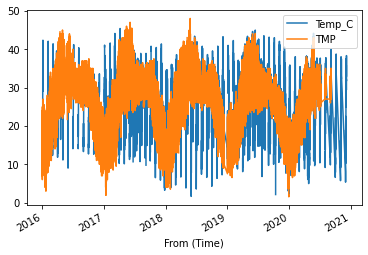

In [47]:
#Checking temperature values between the NOAA and CPCB values.
plt.figure()
df_merge['Temp_C'].plot(legend='CPCB')
df_merge['TMP'].plot(legend='NOAA')
#df_merge['Temp_C'].resample('5D').mean().plot(legend='CPCB')
#df_merge['TMP'].resample('5D').mean().plot(legend='NOAA')

In [48]:
# Save as csv file
df_merge.to_csv('/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #2/Raw Data_CPCB_Lucknow/Cleaned Data Frames/Master_Dataset_2016_2020.csv')